**ÉTAPE 0** : préparation des données

In [2]:
import pandas as pd 
import process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

In [4]:
import warnings 


warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window_0 = [4213, 4273]
number_of_clusters = 38
sigma = 10e-2
clustering_method = 'signed_laplacian' 
number_of_repetition = 25
number_of_window=250
evaluation_window = 1
eta_values = np.linspace(0.001, 0.02, 20)
np.set_printoptions(precision=4, suppress=True)

overall_return, PnL, portfolio_value, sharpe_ratio, daily_PnL = process.sliding_window(df_cleaned=df_cleaned, lookback_window_0=lookback_window_0, number_of_clusters=number_of_clusters, sigma=sigma, clustering_method=clustering_method, number_of_repetition=number_of_repetition, number_of_window=number_of_window, evaluation_window=evaluation_window, eta=0.01)

1.0004000640760011
step 1
1.0042577490860587
step 2
1.0030151674246135
step 3
1.0048102160163692
step 4
1.004068372777711
step 5
1.005948799591434
step 6
1.006428340796594
step 7
1.005477254643411
step 8
1.0058237824778231
step 9
1.003847759830101
step 10
1.004277376435041
step 11
1.0024637371297953
step 12
1.0032094826940101
step 13
1.0033351677832996
step 14
1.005379641812732
step 15
1.007092902858356
step 16
1.0078686381379989
step 17
1.0084250162306678
step 18
1.0052470859037193
step 19
1.0095199118705893
step 20
1.0074419464204438
step 21
1.0113421497564854
step 22
1.0130105712456985
step 23
1.0132072935993937
step 24
1.0123584488780002
step 25
1.0153117490323091
step 26
1.0190680287643399
step 27
1.0208562445767333
step 28
1.0205736867540762
step 29
1.0221082938870807
step 30
1.0253272724294544
step 31
1.0258215036325842
step 32
1.0272583384689842
step 33
1.028875429182869
step 34
1.0291553936986146
step 35
1.0301546927068161
step 36
1.0333492762977263
step 37
1.0336931349449656


In [7]:
df_overall = pd.DataFrame(daily_PnL, columns=['Overall Return'])

df_overall.to_csv('overall_return_2017_SL.csv', index=False)


In [9]:
## pip install yfinance 
import yfinance as yf


def get_sp500_PnL(start_date, end_date):

    # Specify the ticker symbol for S&P 500
    ticker_symbol = "^GSPC"

    # Fetch historical data
    sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    sp500_data['Daily PnL'] = (sp500_data['Close'] - sp500_data['Open']) / sp500_data['Open'][0] ## /100 because we initially invest 1 dollar in our portfolio?
    sp500_PnL = sp500_data['Daily PnL'].transpose() ## we remove the -2 values to have matching values

    return sp500_PnL

start_date = '2017-01-01'
end_date = '2017-12-31'
sp500_PnL = get_sp500_PnL(start_date, end_date)
sp500_PnL.index

[*********************100%%**********************]  1 of 1 completed


DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

In [22]:
PnL_SPONGE = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2017/PnL_2017_SPONGE.csv')

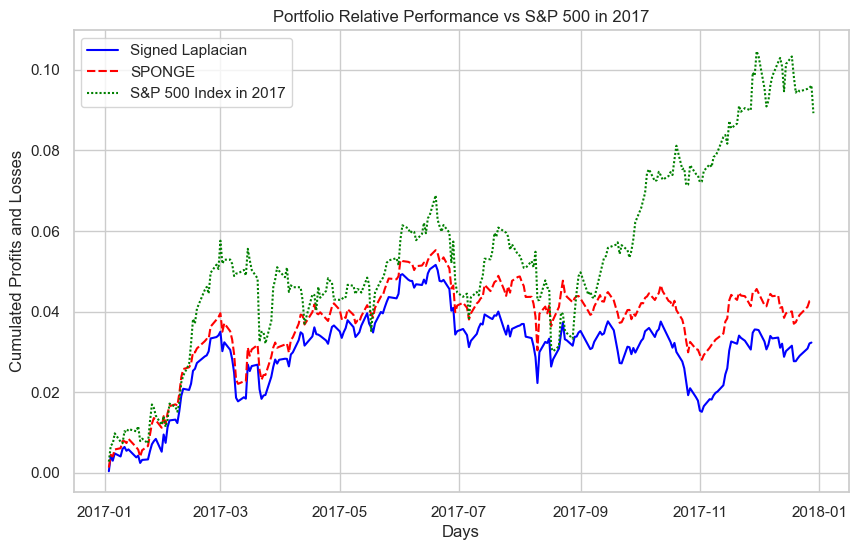

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Calculate the cumulative returns
portfolio_cumulative_SL = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=['Signed Laplacian Portfolio Performance in 2017'], data=PnL)
portfolio_cumulative_SPONGE = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=['SPONGE Portfolio Performance in 2017'], data=PnL_SPONGE.values)

# Combine dataframes for seaborn plotting
combined_df = pd.concat([portfolio_cumulative_SL, portfolio_cumulative_SPONGE, sp500_PnL.cumsum()], axis=1)
combined_df.columns = ['Signed Laplacian', 'SPONGE', 'S&P 500 Index in 2017']

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, palette=['blue', 'red', 'green'])
plt.xlabel('Days')
plt.ylabel('Cumulated Profits and Losses')
plt.title('Portfolio Relative Performance vs S&P 500 in 2017')
plt.legend()
plt.show()

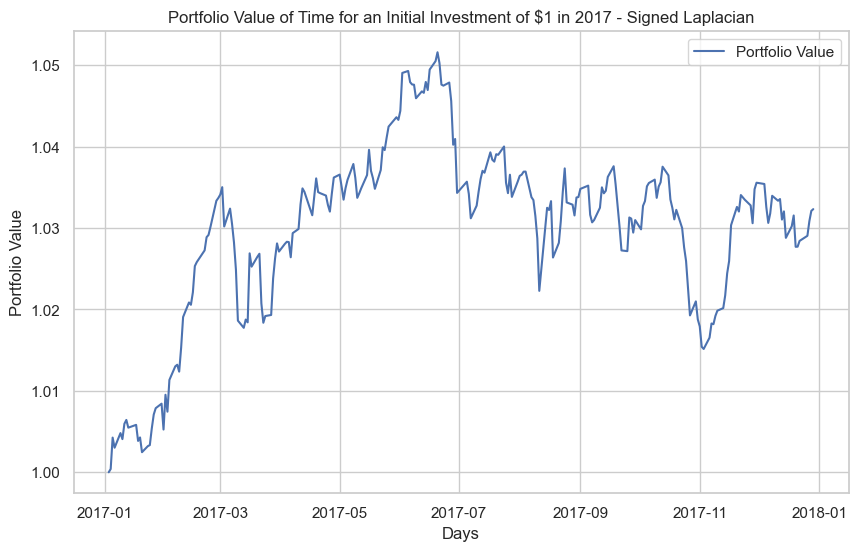

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)

portfolio_value = pd.DataFrame(index = sp500_PnL.index, columns=['Portfolio Value'], data=portfolio_value)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer la PnL cumulative avec seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_value, color='blue')

# Ajouter des titres et des légendes
plt.title('Portfolio Value of Time for an Initial Investment of $1 in 2017 - Signed Laplacian')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')

# Afficher le graphique
plt.show()

In [14]:
# Assurez-vous que les données de portefeuille ne contiennent pas de valeurs manquantes
portfolio_value = portfolio_value.dropna()

# Calcul du rendement global du portefeuille
overall_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1

# Calcul du Sharpe ratio
sharpe = overall_return / (portfolio_value.pct_change().std() * np.sqrt(252))

# Afficher les résultats
print("Sharpe Ratio:", sharpe)
print("Portfolio Return:", overall_return)

Sharpe Ratio: Portfolio Value    0.941489
dtype: float64
Portfolio Return: Portfolio Value    0.032325
dtype: float64


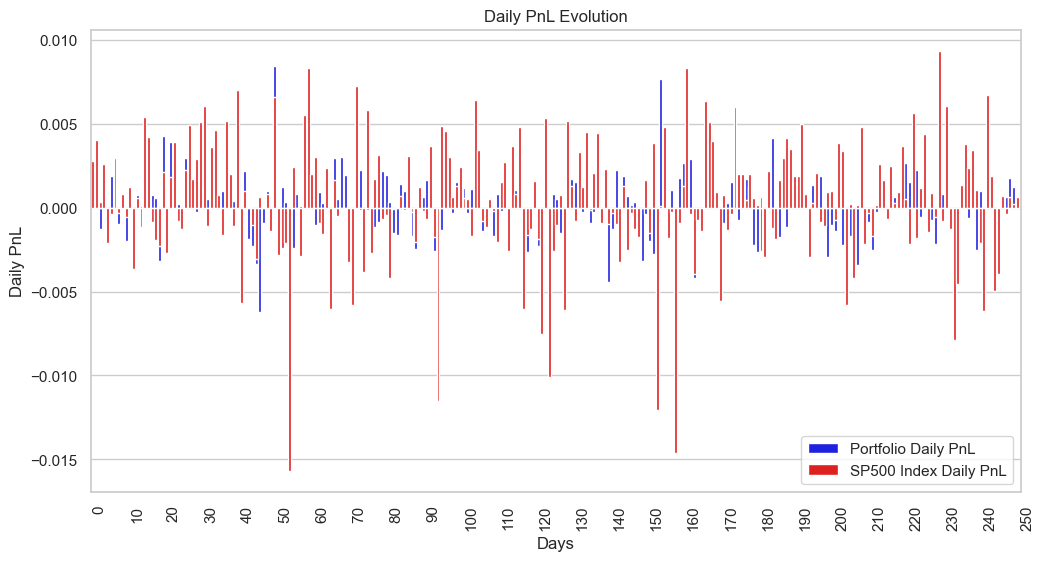

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)
days = np.arange(1, len(daily_PnL) + 1)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer l'évolution quotidienne de la PnL sous forme de diagramme à barres avec seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=days, y=daily_PnL, color='blue', width=0.8, label='Portfolio Daily PnL')  # Ajustez la largeur ici
ax = sns.barplot(x=days, y=sp500_PnL.iloc[:-1], color='red', width=0.8, label='SP500 Index Daily PnL')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés avec un ajustement
ax.set_xticks(np.arange(0,251,10))
ax.set_xticklabels(ax.get_xticks(), rotation=90, ha='right', rotation_mode='anchor')

# Ajouter des titres et des légendes
plt.title('Daily PnL Evolution')
plt.xlabel('Days')
plt.ylabel('Daily PnL')
plt.legend()

# Afficher le graphique
plt.show()
